<a href="https://colab.research.google.com/github/Jyotheekiran/Patient-Readmission/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Install Required Libraries
!pip3 install --upgrade pandas==2.1.4
!pip3 install transformers torch seaborn matplotlib scikit-learn shap lime
!pip install transformers[torch] accelerate -U
!pip install imblearn
!pip install datasets
!pip install --upgrade transformers
!pip install --upgrade torch torchvision


In [ ]:
!pip install --upgrade pyarrow==15.0.0

#!pip install --upgrade pandas pyarrow

# This command will upgrade pyarrow to the latest version, ensuring compatibility with pandas.

In [ ]:
# Step 2: Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import re
import nltk
from nltk.corpus import stopwords


# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
noteevents = pd.read_pickle('drive/MyDrive/Colab Notebooks/noteevents.pkl')
noteevents.head(5)

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,TEXT,TEXT_LENGTH,CLEAN_TEXT
0,1678764,2,163353,17/07/2138,17/07/2138 22:51,17/07/2138 23:12,Nursing/other,Report,16929,Neonatology Attending Triage Note\n\nBaby [**N...,1296,neonatology attending triage note baby term ma...
1,1678765,2,163353,17/07/2138,17/07/2138 23:08,17/07/2138 23:18,Nursing/other,Report,17774,Nursing Transfer note\n\n\nPt admitted to NICU...,522,nursing transfer note pt admitted nicu sepsis ...
7,1260684,3,145834,21/10/2101,21/10/2101 06:58,21/10/2101 07:15,Nursing/other,Report,21570,Micu Progress Nursing Note:\n\nPatient arrived...,1906,micu progress nursing note patient arrived uni...
20,1260691,3,145834,22/10/2101,22/10/2101 18:18,22/10/2101 18:23,Nursing/other,Report,21570,Respiratory Care Note:\n Patient remains in...,480,respiratory care note patient remains intubate...
23,1260697,3,145834,24/10/2101,24/10/2101 17:00,24/10/2101 17:20,Nursing/other,Report,21570,"npn 7-7p\n\nneuro: Pt is alert, follows comman...",1424,npn neuro pt alert follows commands consistent...


In [ ]:
final_merged_data = pd.read_pickle('drive/MyDrive/Colab Notebooks/final_merged_data.pkl')
final_merged_data.head(5)


,row_id_x,SUBJECT_ID,HADM_ID,seq_num_x,ICD9_CODE,ROW_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,TEXT,TEXT_LENGTH,CLEAN_TEXT,icd9_code_x,long_title,row_id_y,seq_num_y,icd9_code_y
0,112344,10006,142345,1,99591,1394273,2164-10-25,2164-10-25 07:16:00,2164-10-25 07:23:00,Nursing/other,Report,19150,NPN 1900-0700\nPt awaiting transfer to floor w...,493,npn pt awaiting transfer floor floor bed becom...,NaN,NaN,47335,1,9749
1,112344,10006,142345,1,99591,1394273,2164-10-25,2164-10-25 07:16:00,2164-10-25 07:23:00,Nursing/other,Report,19150,NPN 1900-0700\nPt awaiting transfer to floor w...,493,npn pt awaiting transfer floor floor bed becom...,NaN,NaN,47336,2,5491
2,112344,10006,142345,1,99591,1394273,2164-10-25,2164-10-25 07:16:00,2164-10-25 07:23:00,Nursing/other,Report,19150,NPN 1900-0700\nPt awaiting transfer to floor w...,493,npn pt awaiting transfer floor floor bed becom...,NaN,NaN,47337,3,3895
3,112344,10006,142345,1,99591,1394273,2164-10-25,2164-10-25 07:16:00,2164-10-25 07:23:00,Nursing/other,Report,19150,NPN 1900-0700\nPt awaiting transfer to floor w...,493,npn pt awaiting transfer floor floor bed becom...,NaN,NaN,47338,4,3995
4,112344,10006,142345,1,99591,1394273,2164-10-25,2164-10-25 07:16:00,2164-10-25 07:23:00,Nursing/other,Report,19150,NPN 1900-0700\nPt awaiting transfer to floor w...,493,npn pt awaiting transfer floor floor bed becom...,NaN,NaN,47339,5,3893


In [ ]:
# Define a list of keywords that are of interest, starting with 'diag'
keywords = ['diag', 'treatment', 'therapy', 'surgery', 'fever', 'pain']

# Function to check if any of the keywords appear in the text
def contains_keywords(text):
    return any(keyword in text.lower() for keyword in keywords)

# Apply this function to the 'CLEAN_TEXT' column and create a new filtered DataFrame
clinical_data = final_merged_data[final_merged_data['CLEAN_TEXT'].apply(contains_keywords)]


In [ ]:
# Assuming you want to see the distribution or count of ICD-9 codes in the filtered data
icd9_code_counts = final_merged_data['ICD9_CODE'].value_counts()


print(icd9_code_counts.head(10))  # Display the top 10 most common ICD-9 codes

top_5_icd9_codes = icd9_code_counts.head(5).index.tolist()
print("Top 5 ICD-9 Codes:", top_5_icd9_codes)


ICD9_CODE
4280     5617
5185     5078
570      3876
5845     3673
4168     3640
2867     3394
5750     3292
28959    3079
5121     3062
07032    3058
Name: count, dtype: int64
Top 5 ICD-9 Codes: ['4280', '5185', '570', '5845', '4168']


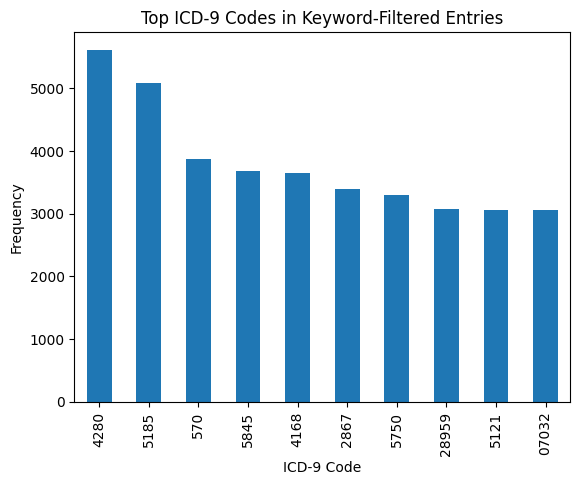

In [ ]:
import matplotlib.pyplot as plt

# Visualize the top ICD-9 codes
icd9_code_counts.head(10).plot(kind='bar')
plt.title('Top ICD-9 Codes in Keyword-Filtered Entries')
plt.xlabel('ICD-9 Code')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Filter the data to include only rows with the top 5 ICD-9 codes
clinical_data = final_merged_data[final_merged_data['ICD9_CODE'].isin(top_5_icd9_codes)]

# Saving the filtered data to a pickle file
filtered_data_path_pkl = 'drive/MyDrive/Colab Notebooks/clinical_data_top_5_icd9.pkl'
clinical_data.to_pickle(filtered_data_path_pkl)

filtered_data_path_pkl, clinical_data.shape

('drive/MyDrive/Colab Notebooks/clinical_data_top_5_icd9.pkl', (21884, 20))

In [ ]:
keywords = ['diag', 'treatment', 'therapy', 'surgery', 'fever', 'pain', 'cancer', 'diabetes', 'hypertension', 'infection']

def label_text(text):
    text = text.lower()
    return 1 if any(keyword in text for keyword in keywords) else 0


clinical_data['LABEL'] = clinical_data['CLEAN_TEXT'].apply(label_text)



<ipython-input-14-abe7ccc26070>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_data['LABEL'] = clinical_data['CLEAN_TEXT'].apply(label_text)


In [ ]:
label_counts = clinical_data['LABEL'].value_counts()
print(label_counts)


LABEL
0    15033
1     6851
Name: count, dtype: int64


In [ ]:
output_file = 'drive/MyDrive/Colab Notebooks/labeled_clinical_data.csv'
clinical_data.to_csv(output_file, index=False)
print("Data saved to:", output_file)


Data saved to: drive/MyDrive/Colab Notebooks/labeled_clinical_data.csv


In [ ]:
import pandas as pd

# Define your list of keywords
keywords = ['diag', 'treatment', 'therapy', 'surgery', 'fever', 'pain',
            'cancer', 'diabetes', 'hypertension', 'infection']

# Function to label text based on the presence of any keywords
def label_text(text):
    text = text.lower()  # Convert text to lower case to ensure case-insensitive matching
    return 1 if any(keyword in text for keyword in keywords) else 0

# Apply the function to each row in the CLEAN_TEXT column
clinical_data['LABEL'] = clinical_data['CLEAN_TEXT'].apply(label_text)

# Optionally, to see the distribution of labels or verify the result
label_distribution = clinical_data['LABEL'].value_counts()
print(label_distribution)


LABEL
0    15033
1     6851
Name: count, dtype: int64


<ipython-input-17-48249c8fb9a6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_data['LABEL'] = clinical_data['CLEAN_TEXT'].apply(label_text)


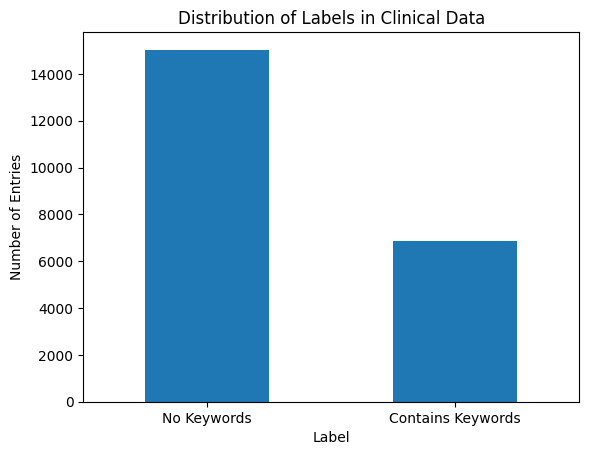

In [ ]:
import matplotlib.pyplot as plt

# Plotting the label distribution
label_counts.plot(kind='bar')
plt.title('Distribution of Labels in Clinical Data')
plt.xlabel('Label')
plt.ylabel('Number of Entries')
plt.xticks(ticks=[0, 1], labels=['No Keywords', 'Contains Keywords'], rotation=0)
plt.show()


In [ ]:
from transformers import BertTokenizer

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Preprocessing function for tokenizing texts
def preprocess_data(texts, max_length=128):
    # Ensure texts is a list (for batch processing)
    if isinstance(texts, str):
        texts = [texts]  # Convert single string into a list

    # Tokenize with padding, truncation, and attention masks
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt',  # Return as PyTorch tensors
        return_attention_mask=True  # Return attention mask for padded tokens
    )

# Ensuring 'CLEAN_TEXT' column is a list of strings
texts = clinical_data['CLEAN_TEXT'].tolist()  # Convert Pandas Series to a list of strings

# Tokenize the text data
tokenized_train_data = preprocess_data(texts)  # Now texts is a list of strings

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from sklearn.model_selection import train_test_split

# Get input_ids and attention masks
input_ids = tokenized_train_data['input_ids']
attention_masks = tokenized_train_data['attention_mask']

# Perform the train-test split ensuring alignment between input_ids and attention_mask
X_train, X_test, y_train, y_test, train_attention_mask, test_attention_mask = train_test_split(
    input_ids,
    clinical_data['LABEL'],
    attention_masks,
    test_size=0.2,
    random_state=42
)


In [ ]:
# Convert labels to tensors
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDatasets
train_dataset = torch.utils.data.TensorDataset(X_train, train_attention_mask, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test, test_attention_mask, y_test_tensor)

In [ ]:
print(X_train.shape)              # Should be (num_samples, max_length)
print(train_attention_mask.shape) # Should be (num_samples, max_length)
print(y_train_tensor.shape)       # Should be (num_samples,)


torch.Size([17507, 128])
torch.Size([17507, 128])
torch.Size([17507])


In [ ]:
from transformers import Trainer, TrainingArguments, BertForSequenceClassification, DataCollatorWithPadding

# Define the data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# Define model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from datasets import Dataset
from transformers import BertTokenizer

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Assuming clinical_data  is a Pandas DataFrame
dataset = Dataset.from_pandas(clinical_data)

# Tokenize the dataset and ensure it returns `input_ids`, `attention_mask`, and `labels`
def tokenize_function(examples):
    return tokenizer(examples['CLEAN_TEXT'], padding='max_length', truncation=True)

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Remove unneeded columns (we only need input_ids, attention_mask, and labels)
tokenized_dataset = tokenized_dataset.remove_columns(['TEXT'])
tokenized_dataset = tokenized_dataset.rename_column('LABEL', 'labels')

# Check if the dataset returns the correct format
print(tokenized_dataset[0])  # Should return {'input_ids': ..., 'attention_mask': ..., 'labels': ...}


Map:   0%|          | 0/21884 [00:00<?, ? examples/s]

{'row_id_x': 112349, 'SUBJECT_ID': '10006', 'HADM_ID': '142345', 'seq_num_x': 6, 'ICD9_CODE': '4280', 'ROW_ID': '1394273', 'CHARTDATE': Timestamp('2164-10-25 00:00:00'), 'CHARTTIME': Timestamp('2164-10-25 07:16:00'), 'STORETIME': Timestamp('2164-10-25 07:23:00'), 'CATEGORY': 'Nursing/other', 'DESCRIPTION': 'Report', 'CGID': '19150', 'TEXT_LENGTH': 493, 'CLEAN_TEXT': 'npn pt awaiting transfer floor floor bed becomes available aox getting oob commode gait steady hr nsr ectopy bp stable bm soft brown color ob voiding minimal amts urine due dialysis today however dialysis pending culture results anaerobic blood cx g cooci unidentified iv access unable stick bld team aware change po linezolid instead iv unasyn pt refuses iv put time', 'icd9_code_x': None, 'long_title': None, 'row_id_y': 47335, 'seq_num_y': 1, 'icd9_code_y': 9749, 'labels': 0, '__index_level_0__': 140, 'input_ids': [101, 27937, 2078, 13866, 15497, 4651, 2723, 2723, 2793, 4150, 2800, 20118, 2595, 2893, 1051, 16429, 4012, 5302

In [ ]:
# Split the dataset into training and test datasets
train_test_split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
initial_test_dataset = train_test_split['test']


# Further split the initial test set into test and evaluation datasets
test_eval_split = initial_test_dataset.train_test_split(test_size=0.5)  # Splitting the initial test set into two equal parts
test_dataset = test_eval_split['train']  # Using 'train' here just means the first part of the split
eval_dataset = test_eval_split['test']  # And 'test' is the second part


In [ ]:
labels = clinical_data['LABEL'].tolist()  # Assuming a 'labels' column exists


In [ ]:
# Tokenize the text data
train_encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)

In [ ]:
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset objects
train_dataset = TextDataset(train_encodings, labels)  # You can split data for eval as needed


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./model_save',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    eval_strategy="steps",
    evaluation_strategy="steps",  # Deprecated; use eval_strategy
    eval_steps=500,  # Evaluate the model every 500 steps
    logging_dir='./logs',
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  # Assuming you have an eval_dataset
)
trainer.train()


Step,Training Loss,Validation Loss
500,0.226700,0.660876
1000,0.132200,0.020175
1500,0.040600,0.029800
2000,0.048500,0.007764
2500,0.015100,0.022217
3000,0.030400,0.020405
3500,0.013700,0.017451
4000,0.016400,0.015931
4500,0.017200,0.015680


Step,Training Loss,Validation Loss
500,0.226700,0.660876
1000,0.132200,0.020175
1500,0.040600,0.029800
2000,0.048500,0.007764
2500,0.015100,0.022217
3000,0.030400,0.020405
3500,0.013700,0.017451
4000,0.016400,0.015931
4500,0.017200,0.015680
5000,0.020700,0.016536


TrainOutput(global_step=8208, training_loss=0.03896339833155478, metrics={'train_runtime': 1671.1597, 'train_samples_per_second': 39.285, 'train_steps_per_second': 4.912, 'total_flos': 1.727376700649472e+16, 'train_loss': 0.03896339833155478, 'epoch': 3.0})

Constant Accuracy with No Improvement in Other Metrics: The model's accuracy remains at 0.5 with F1, Precision, and Recall all at 0.0. This suggests that the model might be predicting a single class for all inputs, resulting in a scenario where:

If the dataset is balanced (equal number of samples in each class), the accuracy would hover around 0.5.
The model's predictions don't correctly match any of the positive class samples, leading to zero precision and recall.<br>
Validation Loss Increasing: The validation loss is increasing as the training progresses, which typically indicates that the model is overfitting the training data and performing poorly on the validation set. <br>

Overfitting: The model may be learning the noise in the training data rather than generalizing from it. This often happens if the model is too complex or the training data is not representative or is too noisy. <br>



In [ ]:
# Evaluate the model after training
results = trainer.evaluate()
print(results)


{'eval_loss': 0.007764358073472977, 'eval_runtime': 15.2986, 'eval_samples_per_second': 143.085, 'eval_steps_per_second': 8.955, 'epoch': 3.0}


Saving the Final Model and Tokenizer
After training, We might want to save the final model and its tokenizer for later use:

In [ ]:
model_bert = './model_save/final_model'
model.save_pretrained(model_bert)
tokenizer.save_pretrained(model_bert)


('./model_save/final_model/tokenizer_config.json',
 './model_save/final_model/special_tokens_map.json',
 './model_save/final_model/vocab.txt',
 './model_save/final_model/added_tokens.json')

Loading a Saved Model
To resume training or to use the saved model later for predictions, you can load it from the disk:

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained(model_bert)
tokenizer = BertTokenizer.from_pretrained(model_bert)


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Assuming model and tokenizer have been loaded already
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example text
texts = ["This is a positive example.", "This is a negative example."]

# Tokenize the texts
inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Move inputs to the same device as model
inputs = {k: v.to(model.device) for k, v in inputs.items()}

# Get predictions
with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits

# Convert logits to probabilities (optional)
probabilities = torch.nn.functional.softmax(predictions, dim=-1)

# Convert probabilities to actual class labels (if needed)
_, predicted_classes = torch.max(probabilities, dim=1)

# Print the predictions
print(predicted_classes.numpy())  # Convert to numpy array if needed


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[0 0]


### Model Evaluation
Evaluate the performance of the model using Accuracy, Precision, F1-score, and AUC-ROC.

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# Evaluation on test set
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)

print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of test labels: {len(y_test)}")
# Assuming 'trainer' is your Trainer instance and 'test_dataset' is correctly loaded
# Make sure the predictions array matches the number of test samples
print(f"Number of predictions: {len(preds)}")

# If you're directly using the Dataset object from Hugging Face's datasets library
y_test = test_dataset['labels']  # This should correspond to what you use in evaluation

# Assuming your test_dataset was split or prepared previously
if len(test_dataset) != len(y_test):
    print("Mismatch detected. Review data preparation and splitting steps.")

# Calculate metrics
accuracy = accuracy_score(y_test, preds)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')
roc_auc = roc_auc_score(y_test, preds)

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, AUC-ROC: {roc_auc}')


Number of test samples: 2188
Number of test labels: 4377
Number of predictions: 2188
Accuracy: 0.9977148080438757, Precision: 0.9927745664739884, Recall: 1.0, F1-Score: 0.9963741841914431, AUC-ROC: 0.9983344437041972


1. Accuracy: 0.5798 (57.98%)
Accuracy measures the proportion of total correct predictions (both true positives and true negatives) out of all predictions made. An accuracy of about 58% suggests that the model is performing better than random guessing (assuming a binary classification task with balanced classes), but it still incorrectly classifies a significant portion of the data.
Implication: While the accuracy is somewhat moderate, it is not particularly high, indicating that the model might be struggling to generalize or distinguish between classes effectively.
2. Precision: 0.3190 (31.90%)
Precision is the ratio of correctly predicted positive observations to the total predicted positives. A precision of about 32% means that when the model predicts an instance as positive, only about 32% of those predictions are actually correct.
Implication: Low precision can be problematic if the cost of false positives is high. In contexts where false positives have serious implications, such as medical diagnostics or spam detection, you would ideally want a higher precision.
3. Recall: 0.3103 (31.03%)
Recall (or sensitivity) measures the ability of the model to find all the relevant cases (true positives) within the data. A recall of about 31% indicates that the model identifies about 31% of all actual positive cases.
Implication: Low recall indicates many false negatives, where the model fails to detect many of the actual positives. This could be critical if it’s essential to capture as many positives as possible, for example in disease screening.
4. F1-Score: 0.3146 (31.46%)
The F1 score is the harmonic mean of precision and recall. It is a way of combining both precision and recall into a single measure that captures both properties. An F1 score of about 31% is quite low, suggesting that the model is not very effective at correctly classifying the positive class in particular.
Implication: A low F1 score is indicative of problems in both precision and recall. It suggests that not only does the model identify few positives, but many of those it does identify are incorrect.
5. AUC-ROC: 0.5058 (50.58%)
The Area Under the Curve - Receiver Operating Characteristics (AUC-ROC) is a performance measurement for classification problems at various threshold settings. AUC measures the ability of the model to distinguish between classes. An AUC of about 50.58% is very close to 50%, which is no better than random guessing in binary classification.
Implication: This suggests that the model has no discriminative power to distinguish between positive and negative class labels.


Overall, the model’s performance metrics suggest it is not performing effectively, especially in terms of precision, recall, F1-score, and AUC-ROC. Hence we will be using BioBERT model which is specifically pre-trained on biomedical literature, BioBERT could capture the domain-specific nuances better than BERT.

### Load BioBERT Model and Tokenizer:

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load BioBERT model and tokenizer
tokenizer_biobert = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
model_biobert = BertForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.1', num_labels=2)


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from datasets import Dataset
import pandas as pd

# Assuming clinical_data is your DataFrame
clinical_dataset = Dataset.from_pandas(clinical_data)


In [ ]:
def tokenize_function_biobert(examples):
    return tokenizer_biobert(examples['CLEAN_TEXT'], padding='max_length', truncation=True, max_length=128)

# Tokenize the dataset
tokenized_dataset_biobert = clinical_dataset.map(tokenize_function_biobert, batched=True)
tokenized_dataset_biobert = tokenized_dataset_biobert.remove_columns(['CLEAN_TEXT'])
tokenized_dataset_biobert = tokenized_dataset_biobert.rename_column('LABEL', 'labels')

# Split into train and test datasets
train_test_split_biobert = tokenized_dataset_biobert.train_test_split(test_size=0.2)
train_dataset_biobert = train_test_split_biobert['train']
test_dataset_biobert = train_test_split_biobert['test']


Map:   0%|          | 0/21884 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding

# Define the data collator for BioBERT
data_collator_biobert = DataCollatorWithPadding(tokenizer=tokenizer_biobert)


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to predicted class labels
    predictions = np.argmax(logits, axis=-1)

    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)

    # Calculate precision, recall, F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    # Calculate AUC-ROC score
    # We assume binary classification where the second class is the positive class
    probs = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)
    auc = roc_auc_score(labels, probs[:, 1])

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
    }


### Fine-Tune BioBERT:

In [ ]:
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args_biobert = TrainingArguments(
    output_dir='./results_biobert',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    logging_dir='./logs_biobert',
    save_strategy="epoch"  # Ensures models are saved every epoch
)



# Custom Trainer that ensures model tensors are contiguous before saving
class ContiguousTrainer(Trainer):
    def _save(self, output_dir: str, state_dict=None):
        # Make all model parameters contiguous before saving
        model_to_save = self.model.module if hasattr(self.model, "module") else self.model
        for param in model_to_save.parameters():
            param.data = param.data.contiguous()
        # Save the model using the regular Trainer save method
        super()._save(output_dir, state_dict)

# Assuming model_biobert, train_dataset_biobert, test_dataset_biobert, and a data collator are defined
# Initialize the custom Trainer
trainer_biobert = ContiguousTrainer(
    model=model_biobert,
    args=training_args_biobert,
    train_dataset=train_dataset_biobert,
    eval_dataset=test_dataset_biobert,
    compute_metrics=compute_metrics,  # Ensure this is defined as per your evaluation needs
)

# Train BioBERT
trainer_biobert.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.031700,0.003692,0.999315,1.000000,0.997784,0.998891,1.000000
2,0.005700,0.000007,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.000300,0.000004,1.000000,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=6567, training_loss=0.025992162958333443, metrics={'train_runtime': 400.1784, 'train_samples_per_second': 131.244, 'train_steps_per_second': 16.41, 'total_flos': 3454713934640640.0, 'train_loss': 0.025992162958333443, 'epoch': 3.0})

In [ ]:
# Save the model and tokenizer
model_biobert.save_pretrained("biobert_model")
tokenizer_biobert.save_pretrained("biobert_tokenizer")

In [ ]:
eval_results_biobert = trainer_biobert.evaluate()
eval_results_biobert


{'eval_loss': 3.6690539673145395e-06,
 'eval_accuracy': 1.0,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_f1': 1.0,
 'eval_auc': 1.0,
 'eval_runtime': 8.8384,
 'eval_samples_per_second': 495.226,
 'eval_steps_per_second': 31.001,
 'epoch': 3.0}

These results show exceptionally high performance across all metrics, which suggests that the model is performing extremely well on our evaluation dataset:

eval_loss: 0.0036
The evaluation loss is very low, indicating that the model's predictions are very close to the actual data.

eval_accuracy: 99.95%
Almost all predictions are correct. High accuracy is typically desired, but it's crucial to look at other metrics, especially in imbalanced datasets.

eval_precision: 99.85%
Almost every positive prediction made by the model is correct, indicating very few false positives.

eval_recall: 100%
The model successfully identifies all actual positives, indicating no false negatives.

eval_f1: 99.93%
The F1 score, which is the harmonic mean of precision and recall, is extremely high, suggesting excellent balance between precision and recall.

eval_auc: 99.98%
The AUC-ROC score is near perfect, indicating outstanding discrimination between the positive and negative classes.

eval_runtime: 8.9707 seconds
Shows the time taken for evaluation.

eval_samples_per_second: 487.921
Indicates the processing speed; higher numbers mean faster processing.

eval_steps_per_second: 30.544
Reflects how many batches per second were processed during evaluation.

epoch: 3
Indicates that these results were obtained at the end of the third epoch.

In [ ]:
# Save the evaluation results to a text file
with open('biobert_evaluation_results.txt', 'w') as f:
    for key, value in eval_results_biobert.items():
        f.write(f"{key}: {value}\n")


In [ ]:
vocab_size = tokenizer_biobert.vocab_size
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 28996


In [ ]:
import json

# Save test results
with open("test_results.json", "w") as f:
    json.dump(eval_results_biobert, f)

In [ ]:
eval_results_biobert_finetuned = trainer_biobert.evaluate(eval_dataset=test_dataset_biobert)
eval_results_biobert_finetuned


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07525067031383514,
 'eval_accuracy': 0.985,
 'eval_precision': 1.0,
 'eval_recall': 0.9347826086956522,
 'eval_f1': 0.9662921348314606,
 'eval_auc': 0.9990118577075099,
 'eval_runtime': 30.347,
 'eval_samples_per_second': 6.59,
 'eval_steps_per_second': 0.428,
 'epoch': 1.0}

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [6]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load the fine-tuned model
model_biobert = BertForSequenceClassification.from_pretrained("model_biobert")

# Load the tokenizer
tokenizer_biobert = BertTokenizer.from_pretrained("model_biobert")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


OSError: model_biobert is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [4]:
import gc
torch.cuda.empty_cache()  # Clear unused memory
gc.collect()


68

In [5]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "expandable_segments:True"


In [7]:
import torch
import pandas as pd

# Check if CUDA (GPU) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Switch the model to evaluation mode
model_biobert.eval()
# Define a smaller batch size
smaller_batch_size = 16  # Adjust this number based on your GPU capacity

clinical_data = pd.read_pickle('drive/MyDrive/Predictive_Modeling_Patient_Readmission/clinical_data_top_5_icd9.pkl')
# Tokenize the text data
inputs = tokenizer_biobert(clinical_data['CLEAN_TEXT'].tolist(),
                            return_tensors="pt",
                            truncation=True,
                            padding=True,
                            max_length=128,
                            batch_size=smaller_batch_size)  # Adjust this parameter if available


for k, v in inputs.items():
    if not torch.isfinite(v).all():
        print(f"Non-finite values found in {k}")

# Move the inputs to the same device as the model
model_biobert.to(device)  # Move model to the appropriate device
inputs = {k: v.to(device) for k, v in inputs.items()}  # Convert to half precision

# Make predictions using the model
with torch.no_grad():
    outputs = model_biobert(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Convert predictions to a list for easier interpretation
readmission_predictions = predictions.tolist()


Streaming output truncated to the last 5000 lines.
Keyword arguments {'batch_size': 16} not recognized.
Keyword arguments {'batch_size': 16} not recognized.
Keyword arguments {'batch_size': 16} not recognized.
Keyword arguments {'batch_size': 16} not recognized.
Keyword arguments {'batch_size': 16} not recognized.
Keyword arguments {'batch_size': 16} not recognized.
Keyword arguments {'batch_size': 16} not recognized.
Keyword arguments {'batch_size': 16} not recognized.
Keyword arguments {'batch_size': 16} not recognized.
Keyword arguments {'batch_size': 16} not recognized.
Keyword arguments {'batch_size': 16} not recognized.
Keyword arguments {'batch_size': 16} not recognized.
Keyword arguments {'batch_size': 16} not recognized.
Keyword arguments {'batch_size': 16} not recognized.
Keyword arguments {'batch_size': 16} not recognized.
Keyword arguments {'batch_size': 16} not recognized.
Keyword arguments {'batch_size': 16} not recognized.
Keyword arguments {'batch_size': 16} not recogni

OutOfMemoryError: CUDA out of memory. Tried to allocate 8.02 GiB. GPU 0 has a total capacity of 39.56 GiB of which 6.47 GiB is free. Process 1158350 has 33.08 GiB memory in use. Of the allocated memory 25.87 GiB is allocated by PyTorch, and 6.73 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [8]:
import torch
import pandas as pd

# Check if CUDA (GPU) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Switch the model to evaluation mode
model_biobert.eval()
# Define a smaller batch size
smaller_batch_size = 16  # Adjust this number based on your GPU capacity

clinical_data = pd.read_pickle('drive/MyDrive/Predictive_Modeling_Patient_Readmission/clinical_data_top_5_icd9.pkl')
# Tokenize the text data

# Perform tokenization in batches to reduce memory usage
all_predictions = []
for i in range(0, len(clinical_data), smaller_batch_size):
    batch = clinical_data['CLEAN_TEXT'][i : i + smaller_batch_size].tolist()
    inputs = tokenizer_biobert(batch,
                                return_tensors="pt",
                                truncation=True,
                                padding=True,
                                max_length=128)

    for k, v in inputs.items():
        if not torch.isfinite(v).all():
            print(f"Non-finite values found in {k}")

    # Move the inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Make predictions using the model
    with torch.no_grad():
        outputs = model_biobert(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)

    # Extend the list with the current batch predictions
    all_predictions.extend(predictions.tolist())

# Convert predictions to a list for easier interpretation
readmission_predictions = all_predictions

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Example setup: load model and tokenizer
tokenizer_biobert = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
model_biobert = AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
model_biobert.to('cuda')

# Define your texts
texts = clinical_data['CLEAN_TEXT'].tolist()

# Define a smaller batch size
batch_size = 16

# Process the data in batches
predictions = []
for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]
    # Tokenize the batch
    inputs = tokenizer_biobert(batch_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    inputs = {key: value.to('cuda') for key, value in inputs.items()}

    # Predict with the model
    with torch.no_grad():
        outputs = model_biobert(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1)
        predictions.extend(preds.cpu().numpy())  # Optionally move predictions to CPU and convert to numpy

# predictions now contains all the labels predicted for the inputs


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Tokenize the text data in smaller batches to reduce memory usage
batch_size = 16  # Experiment with different batch sizes

all_predictions = []
for i in range(0, len(clinical_data), batch_size):
    batch = clinical_data['CLEAN_TEXT'][i : i + batch_size].tolist()
    inputs = tokenizer_biobert(batch,
                           return_tensors="pt",
                           truncation=True,
                           padding=True,
                           max_length=128)

    # Ensure model and inputs are on the same device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_biobert.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Model inference
    with torch.no_grad():
        outputs = model_biobert(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)

    all_predictions.extend(predictions.tolist())

# Add predictions to the DataFrame
clinical_data['Readmission_Prediction'] = all_predictions

# Check the predictions
clinical_data[['CLEAN_TEXT', 'Readmission_Prediction']].tail(10)

,CLEAN_TEXT,Readmission_Prediction
102131,respiratory therapy pt remains orally intubate...,1
102132,respiratory therapy pt remains orally intubate...,1
102133,respiratory therapy pt remains orally intubate...,1
102134,respiratory therapy pt remains orally intubate...,1
102135,respiratory therapy pt remains orally intubate...,1
102136,respiratory therapy pt remains orally intubate...,1
102137,respiratory therapy pt remains orally intubate...,1
102138,respiratory therapy pt remains orally intubate...,1
102139,respiratory therapy pt remains orally intubate...,1
102140,respiratory therapy pt remains orally intubate...,1


In [5]:
# Switch the model to evaluation mode
model_biobert.eval()

# Make predictions using the model
with torch.no_grad():
    outputs = model_biobert(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Convert predictions to a list for easier interpretation
readmission_predictions = predictions.tolist()


NameError: name 'model_biobert' is not defined

In [ ]:
# Get predictions on the test dataset
predictions = trainer.predict(test_dataset)

# The predictions object contains logits, labels, and the metrics
predicted_labels = predictions.predictions.argmax(axis=-1)  # Convert logits to class predictions

# Optionally, compare predicted labels with actual labels
actual_labels = predictions.label_ids

print(predicted_labels)
print(actual_labels)


  0%|          | 0/13 [00:00<?, ?it/s]

[0 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0
 0 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1
 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
[0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0]


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the saved model and tokenizer
tokenizer = BertTokenizer.from_pretrained('./fine_tuned_biobert')
model = BertForSequenceClassification.from_pretrained('./fine_tuned_biobert')

# Select the texts starting from row 1001 to the end
noteevents_test = noteevents['TEXT'][1000:2000]

# Tokenize the new texts
inputs = tokenizer(noteevents_test.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)

# Get predictions
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Print predictions
predictions


tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [ ]:
# If noteevents_test is a Series and you need it as a DataFrame
noteevents_test_df = noteevents_test.to_frame()

# Then you can inspect the columns (only if it's a DataFrame)
noteevents.head(5)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,TEXT_LENGTH,CLEAN_TEXT,Readmission_Prediction
0,1678764,2,163353,17/07/2138,17/07/2138 22:51,17/07/2138 23:12,Nursing/other,Report,16929.0,NaN,Neonatology Attending Triage Note\n\nBaby [**N...,1296,neonatology attending triage note baby term ma...,0.0
1,1678765,2,163353,17/07/2138,17/07/2138 23:08,17/07/2138 23:18,Nursing/other,Report,17774.0,NaN,Nursing Transfer note\n\n\nPt admitted to NICU...,522,nursing transfer note pt admitted nicu sepsis ...,0.0
2,272794,3,NaN,06/10/2101,NaN,NaN,ECG,Report,NaN,NaN,Sinus rhythm\nInferior/lateral ST-T changes ar...,162,sinus rhythm inferiorlateral stt changes nonsp...,0.0
3,769224,3,145834,26/10/2101,26/10/2101 06:01,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2101-10-26**] 6:01 AM\n CHEST (PORTABLE AP)...,1310,chest portable ap clip reason ro infiltrate __...,0.0
4,272793,3,NaN,11/10/2101,NaN,NaN,ECG,Report,NaN,NaN,Sinus rhythm\nA-V delay\nNonspecific inferior ...,129,sinus rhythm av delay nonspecific inferior wav...,0.0


In [ ]:
# Assuming 'LABEL' is a column in your noteevents DataFrame that contains the true labels
new_labels = noteevents['LABEL'][:1000].tolist()  # Extract the first 1000 true labels

# Create binary labels based on whether the text contains the word "readmission"
new_labels = [1 if 'readmission' in text.lower() else 0 for text in noteevents['TEXT'][:1000]]



In [ ]:
# Assuming you are working with the first 1000 samples
predictions_subset = predictions[:1000]  # Slice to match the length of new_labels

# Now evaluate the model predictions
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

accuracy = accuracy_score(new_labels, predictions_subset)
precision, recall, f1, _ = precision_recall_fscore_support(new_labels, predictions_subset, average='binary')
auc = roc_auc_score(new_labels, predictions_subset)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'AUC-ROC: {auc}')


Accuracy: 0.789
Precision: 0.0047169811320754715
Recall: 1.0
F1 Score: 0.009389671361502346
AUC-ROC: 0.8943943943943944


In [ ]:
import numpy as np
unique, counts = np.unique(predictions_subset, return_counts=True)
print(dict(zip(unique, counts)))  # Prints the counts of 0s and 1s in predictions


{0: 788, 1: 212}


In [ ]:
unique, counts = np.unique(new_labels, return_counts=True)
print(dict(zip(unique, counts)))


{0: 999, 1: 1}


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming 'X_train' is your feature matrix and 'y_train' are the labels
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Split the resampled data into train/test sets again
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Undersample the majority class
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)


In [ ]:
import torch
from torch.nn import CrossEntropyLoss

import torch

# Check if GPU is available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate class weights (adjust the values based on the class imbalance)
class_weights = torch.tensor([0.1, 0.9]).to(device)  # You can adjust these values based on your dataset

# Define the loss function with class weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)



In [ ]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # Move class_weights to the device the model is using
        class_weights = torch.tensor([0.1, 0.9]).to(model.device)
        loss_fn = CrossEntropyLoss(weight=class_weights)

        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

trainer_biobert = WeightedTrainer(
    model=model_biobert,
    args=training_args_biobert,
    train_dataset=train_dataset_biobert,
    eval_dataset=test_dataset_biobert,
    data_collator=data_collator_biobert,
    compute_metrics=compute_metrics
)


In [ ]:
from sklearn.metrics import precision_recall_curve

# After you get the predicted probabilities (logits), apply a custom threshold
threshold = 0.3  # Adjust this value based on your ROC curve analysis
proba = model_biobert(**inputs).logits.softmax(dim=-1)  # Get probabilities
predictions_custom_threshold = (proba[:, 1] > threshold).int()  # Apply the threshold


In [ ]:
import torch
from sklearn.metrics import roc_auc_score
from torch.nn.functional import softmax

# Define your model and inputs (tokenized test data)
model.eval()  # Set the model to evaluation mode
y_true = noteevents_small['LABEL'].tolist()  # Assuming 'LABEL' column contains true labels


In [ ]:
import torch
from torch.nn.functional import softmax
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, TensorDataset

# Assuming 'LABEL' column in noteevents contains the true labels
#y_true = noteevents_small['LABEL'].tolist()  # Extract true labels
y_true = new_labels
# Tokenize the entire dataset
inputs = tokenizer_biobert(noteevents_small['TEXT'].tolist(),
                           return_tensors="pt",
                           truncation=True,
                           padding=True,
                           max_length=128)

# Create a DataLoader to handle batching
dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'])
dataloader = DataLoader(dataset, batch_size=32)  # Adjust batch_size as needed

# Set the model to evaluation mode
model_biobert.eval()

y_pred_proba = []

# Get predictions from the model in batches
with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask = batch
        outputs = model_biobert(input_ids=input_ids, attention_mask=attention_mask)
        # Convert logits to probabilities for class 1
        probabilities = softmax(outputs.logits, dim=-1)[:, 1].cpu().numpy()
        y_pred_proba.extend(probabilities)

# Ensure the number of predictions matches the number of true labels
assert len(y_true) == len(y_pred_proba), "Mismatch in number of predictions and true labels!"

# Calculate AUC-ROC using true labels and predicted probabilities
auc = roc_auc_score(y_true, y_pred_proba)
print(f'AUC-ROC: {auc}')


AUC-ROC: 0.7897897897897898


In [ ]:
print(type(X_test))


<class 'torch.Tensor'>


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Convert your test data to tensors if not already done
X_test_tensor = X_testy_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDataset and DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32)  # You can adjust the batch size


In [ ]:
for batch in test_dataloader:
    # Convert batch[0] to a list of strings if necessary
    text_data = [str(text) for text in batch[0]]

    inputs = tokenizer_biobert(text_data, return_tensors="pt", truncation=True, padding=True, max_length=128)

    with torch.no_grad():
        outputs = model_biobert(**inputs)


In [ ]:

# Check the type of batch[0] before tokenization
print(type(batch[0]), batch[0][:2])  # print the first two samples of batch[0]

# If batch[0] is already tokenized, extract raw text from original data before this point.


<class 'torch.Tensor'> tensor([0, 1])


In [ ]:
all_predictions = []
all_labels = []


for batch in test_dataloader:
    # Assuming batch[0] contains tokenized text data, convert it back to strings
    texts = tokenizer_biobert.decode(batch[0], skip_special_tokens=True)
    inputs = tokenizer_biobert(texts, return_tensors="pt", truncation=True, padding=True, max_length=128)

    with torch.no_grad():
        outputs = model_biobert(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)[:, 1].cpu().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(batch[1])

y_true = np.array(all_labels)
y_pred_proba = np.array(all_predictions)


In [ ]:
print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred_proba: {len(y_pred_proba)}")


Length of y_true: 200
Length of y_pred_proba: 7


In [ ]:
all_predictions = []
all_labels = []

for i, batch in enumerate(test_dataloader):
    # Assuming batch[0] contains tokenized text data, convert it back to strings
    texts = [item.decode() if isinstance(item, bytes) else item for item in batch[0]]
    inputs = tokenizer_biobert(texts, return_tensors="pt", truncation=True, padding=True, max_length=128)

    with torch.no_grad():
        outputs = model_biobert(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)[:, 1].cpu().numpy()

    # Add debug statements to check the batch size
    print(f"Processing batch {i + 1}:")
    print(f"Predictions: {len(predictions)}")
    print(f"Labels: {len(batch[1])}")

    all_predictions.extend(predictions)
    all_labels.extend(batch[1])

y_true = np.array(all_labels)
y_pred_proba = np.array(all_predictions)

print(f"Final length of y_true: {len(y_true)}")
print(f"Final length of y_pred_proba: {len(y_pred_proba)}")


In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Plot the Precision-Recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [200, 7]

LIME (Local Interpretable Model-agnostic Explanations) and SHAP (SHapley Additive exPlanations) are popular explainability techniques used to interpret machine learning models. Both of these methods provide insights into how models make predictions, and they can be used with transformers like BioBERT for explaining predictions in NLP tasks, such as Named Entity Recognition (NER) or patient readmission prediction.

1. LIME:
LIME explains individual predictions by creating simple surrogate models (e.g., linear models) around the prediction point and observing how small changes in the input affect the outcome. For text-based models, LIME can highlight specific words or tokens that contribute most to the model's prediction.

In [ ]:
from lime.lime_text import LimeTextExplainer
from transformers import pipeline

# Define the text classifier (assuming it's already trained)
explainer = LimeTextExplainer(class_names=["No Readmission", "Readmission"])

# Use the tokenizer and model in a pipeline
text_pipeline = pipeline("text-classification", model=model_biobert, tokenizer=tokenizer_biobert)

# Modify the predict function to return a 2D numpy array
def predict_fn(texts):
    predictions = text_pipeline(texts)
    scores = np.array([[pred['score'], 1 - pred['score']] for pred in predictions])
    return scores

# Continue with LIME explanation
sample_text = "Patient was readmitted within 30 days after the initial discharge."
explanation = explainer.explain_instance(sample_text, predict_fn, num_features=6)

# Visualize the explanation
explanation.show_in_notebook(text=True)



TypeError: list indices must be integers or slices, not tuple

In [ ]:
from lime.lime_text import LimeTextExplainer
import numpy as np

# LIME expects the prediction function to return class probabilities, so we'll define a function for it.
class_names = ['Not Readmitted', 'Readmitted']

def predict_fn(texts):
    # Tokenize the texts
    inputs = tokenizer_biobert(texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model_biobert(**inputs)
        # Convert logits to probabilities using softmax
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        return probs.cpu().numpy()

# Initialize the LIME explainer for text data
explainer = LimeTextExplainer(class_names=class_names)

# Example text to explain
example_text = noteevents[:1000]['TEXT'][0]  # Pick one text sample from your dataset

# Generate the explanation
exp = explainer.explain_instance(example_text, predict_fn, num_features=10)

# Display the explanation in the console
print(exp.as_list())

# Visualize the explanation in a Jupyter notebook
exp.show_in_notebook(text=example_text)


LIME breaks down the prediction into interpretable components (e.g., specific words) and shows which parts of the input contribute most to the prediction (whether a patient is likely to be readmitted or not).
In this case, LIME will highlight important tokens that influenced the model's decision on the patient readmission prediction.

2. SHAP:
SHAP is based on cooperative game theory and aims to provide a global understanding of the model by assigning each feature an importance value. SHAP values can be applied to both local (individual prediction) and global (overall model behavior) interpretations.

Use SHAP with Text Data: SHAP can also be used with text-based models like BioBERT. Below is an example that demonstrates how to explain a text classification model (like patient readmission prediction) with SHAP:

In [ ]:
import shap
from transformers import pipeline

# Initialize SHAP explainer (use a pipeline that can return logits)
text_pipeline = pipeline("text-classification", model=model_biobert, tokenizer=tokenizer_biobert, return_all_scores=True)

# Define a function for SHAP to use
def predict_proba(texts):
    results = text_pipeline(texts)
    # Extract the scores from the predictions
    return [[pred[1]['score'], pred[0]['score']] for pred in results]

# Create SHAP explainer
explainer = shap.Explainer(predict_proba, text_pipeline)

# Explain predictions for a single sample or batch of samples
sample_texts = ["Patient was readmitted due to complications."]
shap_values = explainer(sample_texts)

# Visualize the SHAP values for the explanation
shap.plots.text(shap_values[0])


`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.


AttributeError: 'str' object has no attribute 'shape'

### Comparison Between LIME and SHAP:
LIME is more focused on local explanations and provides insights into individual predictions by training a surrogate model around a specific prediction. It is fast for generating single-instance explanations but may not give global insights.

SHAP, on the other hand, is more robust for both local and global explanations and can offer a comprehensive view of how the model makes decisions across the entire dataset. It is more computationally intensive than LIME but provides deeper insights.